# Final Model Training Performance Evaluation

#### Optimised HyperParameters:
#### Layer 1 Kernel Size: 100 samples (1000 ns)
#### Layer 2 Kernel Size: 60 samples (600 ns)
#### Layer 1 Filters: 64
#### Layer 2 Filters: 154
#### Stride: 4
#### Pool Size: 3
#### Learning Rate: 5.76249e-04
#### Batch Size: 323

### Key: Cathode = 0, Gate = 1, Tritium = 2

# Imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import random
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import legacy
import seaborn as sn
import pandas as pd
import awkward as ak
import hist
from hist import Hist, axis
from sklearn.model_selection import train_test_split
from scipy.stats import binomtest
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
import time

In [2]:
plt.rcParams['figure.figsize'] = [10, 8]
font = {'weight' : 'normal','size'   : 22}
plt.rc('font', **font)

# Load data from Parquet file and convert to strings
data_path = '/Users/laith_mohajer/Documents/GitHub/MSCIProject/LZ Datasets/padded_waveforms.parquet'
df = pd.read_parquet(data_path)
print(df.head())
arr = ak.from_parquet(data_path) #Awkward DataFrame also created for future use
print(arr.fields) #analogous to df.columns.tolist()

   runID  eventID                                              times  \
0   6940     3177  [-3632.0, -3622.0, -3612.0, -3602.0, -3592.0, ...   
1   6940     7831  [-3642.0, -3632.0, -3622.0, -3612.0, -3602.0, ...   
2   6940     9904  [-1312.0, -1302.0, -1292.0, -1282.0, -1272.0, ...   
3   6940    15136  [-823.0, -813.0, -803.0, -793.0, -783.0, -773....   
4   6940    16478  [-813.0, -803.0, -793.0, -783.0, -773.0, -763....   

                                             samples  length          area  \
0  [0.00036996949347667396, -0.000351915950886905...    1101   9605.476562   
1  [0.0009631378925405443, 0.0009631378925405443,...     932   8454.574219   
2  [-0.003676149994134903, -0.004674938507378101,...     525  10806.775391   
3  [-0.004523166920989752, 0.0026921471580863, -0...     640  11460.135742   
4  [-0.009625015780329704, -0.004182628821581602,...     656  11764.575195   

   max_pulse_height    ext_elec          x          y          r  S2_width  \
0          2.721810 

# Normalising the Data


In this instance, we use awkward arrays. Awkward arrays work very similarly to numpy arrays but they can have different lengths – for example, the times and samples arrays are a different length for every event.

In [3]:
def normalise_array(arr):
    # Normalise each sub-array individually and return as an awkward array
    return ak.Array([
        (sub_array - np.min(sub_array)) / (np.max(sub_array) - np.min(sub_array)) if np.max(sub_array) != np.min(sub_array) else sub_array
        for sub_array in ak.to_list(arr)
    ])

def remove_array_offset(arr):
    # Normalise each sub-array individually and return as an awkward array
    return ak.Array([
        (sub_array - np.min(sub_array)) if np.max(sub_array) != np.min(sub_array) else sub_array
        for sub_array in ak.to_list(arr)
    ])

# Apply normalisation to each column
normalised_times = normalise_array(arr['times'])
normalised_samples = normalise_array(arr['samples'])
normalised_areas = normalise_array(arr['area'])

unnormalised_times = remove_array_offset(arr['times']) # Unnormalised times but shifted to start at zero (offset remove)

print(f"Lengths of first few subarrays in normalised_times: {ak.num(normalised_times, axis=1)[:10]}")
print(f"Example subarray from normalised_times: {normalised_times[0]}")
print(f"Example subarray from unnormalised_times: {unnormalised_times[3654]}")


# Print minimum and length for testing
# print(f"Minimum values of sub-arrays: {[sub_array.min() for sub_array in padded_times]}")
# print(f"Length of sub-array 200: {len(padded_times[200])}")

Lengths of first few subarrays in normalised_times: [1101, 932, 525, 640, 656, 651, 635, 829, 356, 1236]
Example subarray from normalised_times: [0, 0.000909, 0.00182, 0.00273, 0.00364, ..., 0.996, 0.997, 0.998, 0.999, 1]
Example subarray from unnormalised_times: [0, 10, 20, 30, 40, 50, ..., 7.51e+03, 7.52e+03, 7.53e+03, 7.54e+03, 7.55e+03]


# Standardising Length of Data

In [4]:
# Lets pad the time data first using Awkward jargon

# first, an initial check to see if data row entry (training example) has an associated label. filtering for both NaNs and None values.
missing_label_count = len(arr[(arr['label'] != 0) & (arr['label'] != 1) & (arr['label'] != 2)])
print("Number of rows with unexpected or missing labels:", missing_label_count)

nan_areas = len(arr[ak.is_none(arr['area'])])
print("Number of NaN values in area column:", nan_areas)
# print(type(electron_size))

# Convert columns to numpy arrays, pad, and convert back to Awkward Arrays
def pad_to_max_length(array, max_length):
    return ak.Array(
        np.array(
            [np.pad(sub_array, (0, max_length - len(sub_array)), mode='constant', constant_values=0) for sub_array in ak.to_list(array)]
        )
    )

print(len(arr['times']))
print(f"Length Before Padding: {len(arr['times'][0])}")
print("Structure of 'times':", ak.type(arr['times']))

times_lengths = ak.num(arr['times'], axis=1)
max_time_length = ak.max(times_lengths) # returns length of longest time series in dataset
max_time_length_index = ak.argmax(times_lengths)

print(f'Results are: \n Max. Length = {max_time_length} \n Max. Length Index = {max_time_length_index}')

# Apply padding
padded_times = np.array(pad_to_max_length(normalised_times, max_time_length))
unnormalised_padded_times = np.array(pad_to_max_length(unnormalised_times, max_time_length))

sampling_interval_us = 0.01 # interval between consecutive samples in microseconds
time_us = [np.arange(len(wave)) * sampling_interval_us for wave in arr["times"]]
print(time_us[1036]) #TEST: the last element in this row should equal 18.3 µs

print(f"Length After Padding: {len(padded_times[0])}")
print(f"Length After Padding: {len(unnormalised_padded_times[3743])}")

Number of rows with unexpected or missing labels: 0
Number of NaN values in area column: 0
7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
[0.000e+00 1.000e-02 2.000e-02 ... 1.825e+01 1.826e+01 1.827e+01]
Length After Padding: 1828
Length After Padding: 1828


Now lets standardise the Sample data

In [5]:
print(len(arr['samples']))
print(f"Length Before Padding: {len(arr['samples'][0])}")
print("Structure of 'times':", ak.type(arr['samples']))

samples_lengths = ak.num(arr['times'], axis=1)
max_samples_length = ak.max(samples_lengths)
max_samples_length_index = ak.argmax(samples_lengths)

print(f'Results are: \n Max. Length = {max_samples_length} \n Max. Length Index = {max_samples_length_index}')

# Apply padding
padded_samples = np.array(pad_to_max_length(normalised_samples, max_samples_length))

print(f"Length After Padding: {len(padded_samples[0])}")
# print(padded_samples[0][-200:])

7782
Length Before Padding: 1101
Structure of 'times': 7782 * option[var * ?float64]
Results are: 
 Max. Length = 1828 
 Max. Length Index = 1036
Length After Padding: 1828


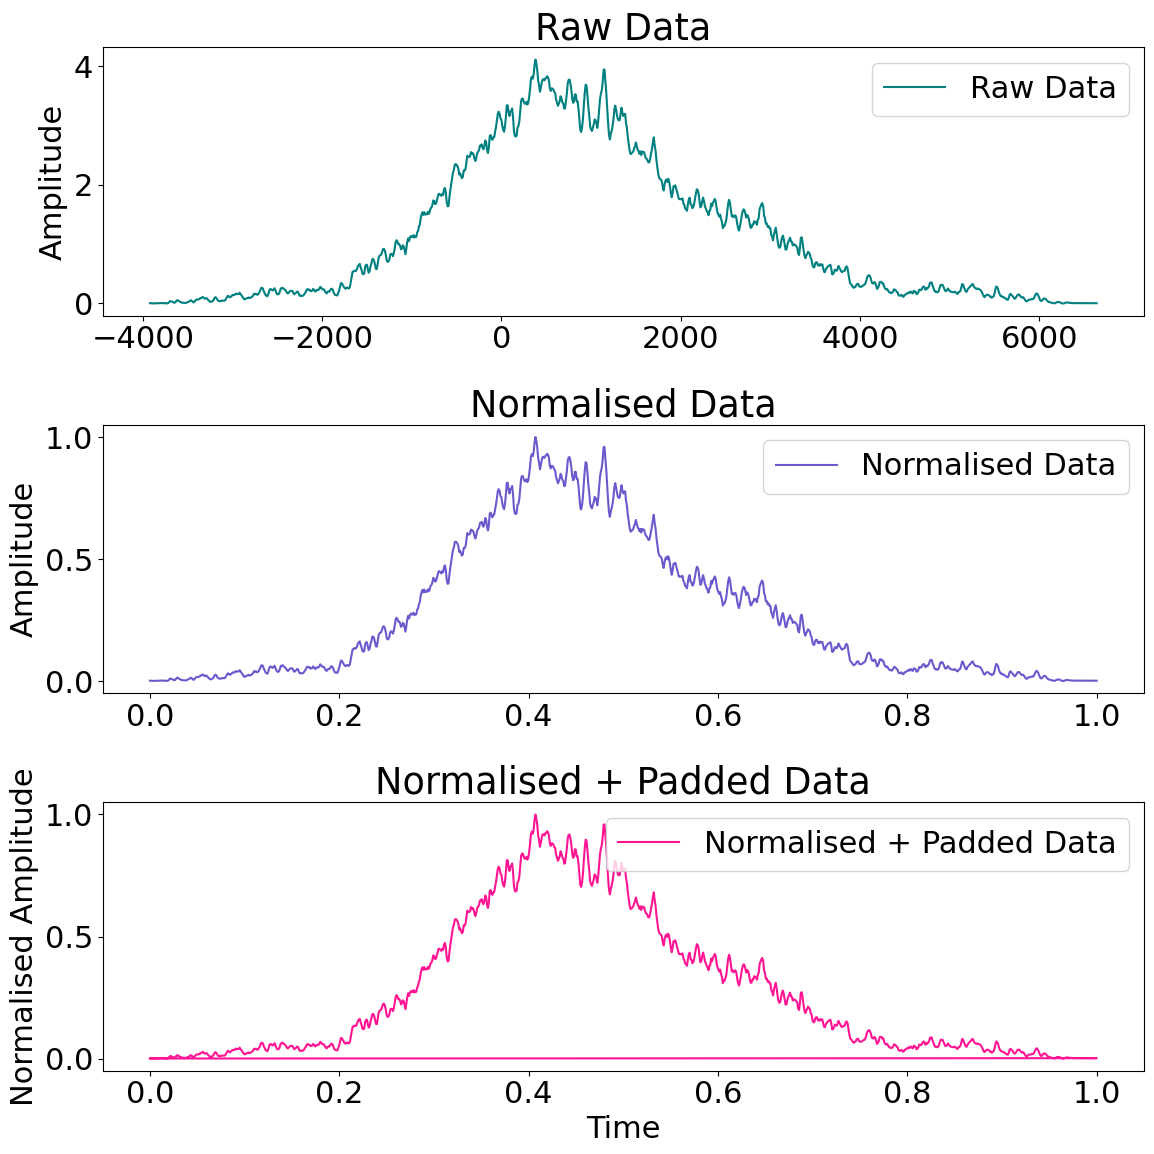

In [6]:
fig, axs = plt.subplots(3, 1, figsize=(12, 12))  # axs is an array of Axes

# Plot the first dataset in the first subplot
axs[0].plot(arr['times'][32], arr['samples'][32], label='Raw Data', color='teal')
axs[0].set_title("Raw Data")
axs[0].set_ylabel("Amplitude")
axs[0].legend()

# Plot the second dataset in the first subplot
axs[1].plot(normalised_times[32], normalised_samples[32], label='Normalised Data', color='slateblue')
axs[1].set_title("Normalised Data")
axs[1].set_ylabel("Amplitude")
axs[1].legend()

# Plot the third dataset in the second subplot
axs[2].plot(padded_times[32], padded_samples[32], label='Normalised + Padded Data', color='deeppink')
axs[2].set_title("Normalised + Padded Data")
axs[2].set_ylabel("Normalised Amplitude")
axs[2].legend()

# Add overall labels
plt.xlabel("Time")

# Adjust spacing between subplots for readability
plt.tight_layout()

# Show the plot
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/errorsinpaddingandnormalising.png')
plt.show()

# Creating the Training and Test Data (AwkwardArrays)

(7782, 2828)
(7782, 2828)


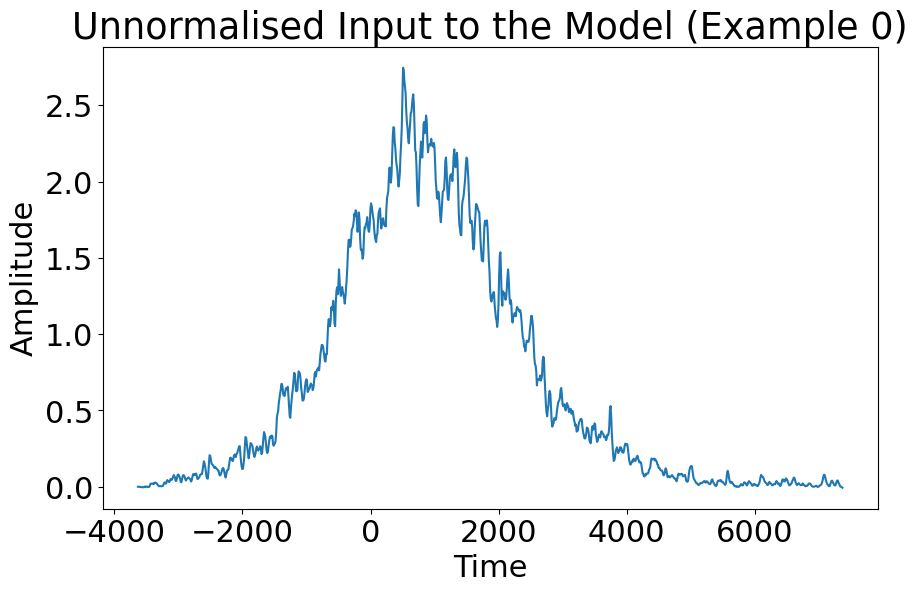

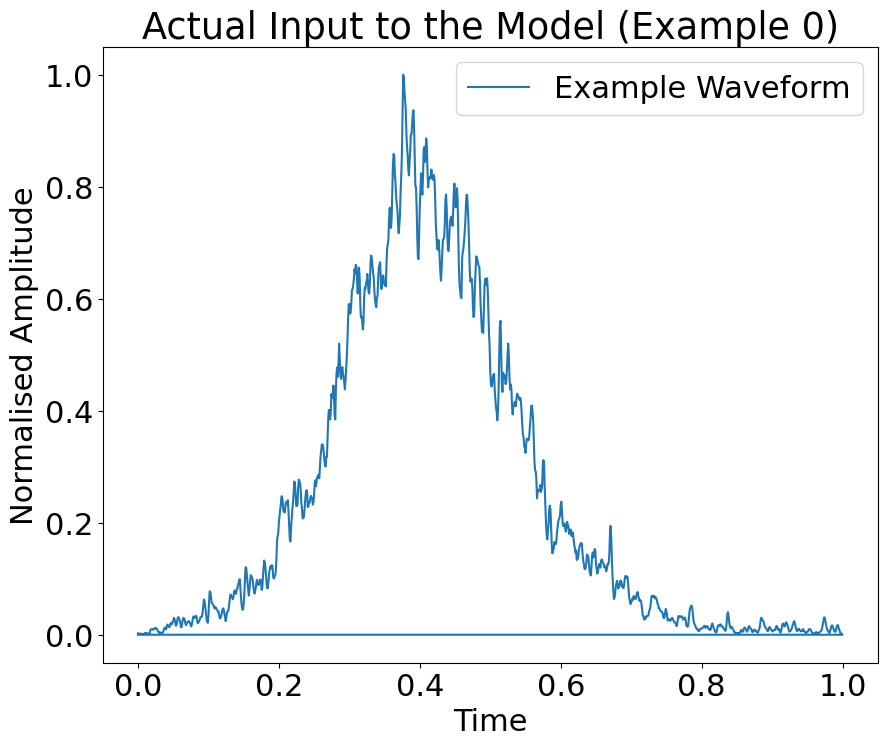

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
# Define padding length
padding_length = 500

# X = arr[['times', 'samples']] #creates a mini array from mother array with only 'times' and 'samples' columns
#print(X)
y = np.array(arr['label']) # labelled as 0,1 and 2 corresponding to cathode, gate and tritium respectively. this is the true output data#

# Add zero-padding on each side of the data (only along the time dimension for 2D data) Then reshape X_train_padded and X_test_padded to 3D
normalised_times_padded = np.pad(padded_times, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
unnormalised_times_padded = np.pad(unnormalised_padded_times, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
normalised_samples_padded = np.pad(padded_samples, ((0, 0), (padding_length, padding_length)), mode='constant', constant_values=0)
X = normalised_samples_padded
print(normalised_times_padded.shape)
print(X.shape)

time_steps = normalised_times_padded.shape[1]
example_index = 0
example_row = X[example_index]

# Split the row into time and samples
example_time = normalised_times_padded[example_index][500:-500]  # The time data of sample index {example_index}
example_samples = example_row[500:-500]  # The sample data of sample index {example_index}

plt.figure(figsize=(10, 6))
plt.plot(arr['times'][0], arr['samples'][0])
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.title(f"Unnormalised Input to the Model (Example {example_index})")

plt.show()
plt.plot(example_time, example_samples, label="Example Waveform")
plt.xlabel("Time")
plt.ylabel("Normalised Amplitude")
plt.title(f"Actual Input to the Model (Example {example_index})")
plt.legend()
# plt.grid(True)
plt.show()

# S2 Area Spectrum

In [8]:
areas = arr['area']
max_area = max(areas)

bins=100
electron_size = 58.5
print(max(areas)/electron_size)

# create a histogram of area distributions for gate, tritium and cathode data.
# first, boolean masks to filter gate, tritium and cathode data from main Awkward Array.
gate_events = arr[(arr['label'] == 1)].area / electron_size
tritium_events = arr[(arr['label'] == 2)].area / electron_size
cathode_events = arr[(arr['label'] == 0)].area / electron_size

gate_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01))
gate_hist.fill(gate_events)

tritium_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size*1.01))
tritium_hist.fill(tritium_events)

cathode_hist = Hist(hist.axis.Regular(bins,0,max(areas)/electron_size *1.01))
cathode_hist.fill(cathode_events)

print(tritium_hist.view())
print(gate_hist.view())
print(cathode_hist.view())

305.75293803418805
[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   4.  14.  12.  33.  39.  49.  65.  67.  65.  76.  66.  93.  90.
  89. 109.  78. 105.  82. 109.  78.  96.  80. 101. 109.  96.  87.  95.
  95.  83.  86.  96.  84. 101.  82.  70.  79.  81.  78.  67.  96.  77.
  71.  70.  78.  67.  59.  67.  61.  59.  58.  58.  43.  53.  44.  55.
  60.  64.  52.  39.  53.  32.  33.  29.  47.  35.  41.  31.  29.  27.
  24.  37.  24.  23.  24.  19.  17.  18.  18.  15.   9.  21.  14.  26.
  16.   0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  5. 13. 43.
 60. 42. 27. 25. 18. 25. 18. 16. 24. 23. 18. 41. 26. 21. 22. 22. 23. 15.
 22. 20. 19. 16. 19. 17. 15. 14. 13. 16. 17. 33. 11. 31. 11. 22. 19. 16.
 14. 18. 21. 24. 16. 17. 19. 18. 25. 24. 23. 27. 17. 32. 18. 23. 23. 17.
 20. 13. 19. 13. 18. 12. 15. 21. 16. 17. 19. 13. 23. 24. 21. 15. 22. 20.
 18. 32. 22. 12. 16. 13. 13. 19. 11.  0.]
[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1. 

In [9]:
bin_edges = gate_hist.axes[0].edges  # Get bin edges from one of the histograms
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2  # Calculate bin centers
print(bin_edges[-2])

# Retrieve and adjust counts for each histogram
gate_counts = gate_hist.view() / bin_centers
tritium_counts = tritium_hist.view() / bin_centers
cathode_counts = cathode_hist.view() / bin_centers

print(cathode_hist.view().sum())
print(tritium_counts[-1])
print(gate_counts[-1])
print(cathode_counts[-1])

305.7223627403846
1189.0
0.0
0.0
0.0032545047259652992


# Weighting the S2 Area Spectrum

MAX areas: tritum,gate, cathode, overall dataset (17881.375, 17847.5546875, 17886.546875, 17886.546875)
13.411785247523326
37.54691093085141
10.274164346048565
[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525 13.41178525
 13.41178525 13.41178525 13.41178525 13.41178525 13.4

/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_71130/1873441013.py:27: RuntimeWarning: divide by zero encountered in double_scalars
  gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_71130/1873441013.py:33: RuntimeWarning: divide by zero encountered in double_scalars
  tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_71130/1873441013.py:39: RuntimeWarning: divide by zero encountered in double_scalars
  cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipykernel_71130/1873441013.py:50: RuntimeWarning: invalid value encountered in multiply
  gate_errors = np.sqrt(gate_counts) * gate_weights /70 # * (average_counts / gate_counts.sum())
/var/folders/8d/lxs1vkm92sx23cl8twt_cnt00000gn/T/ipyke

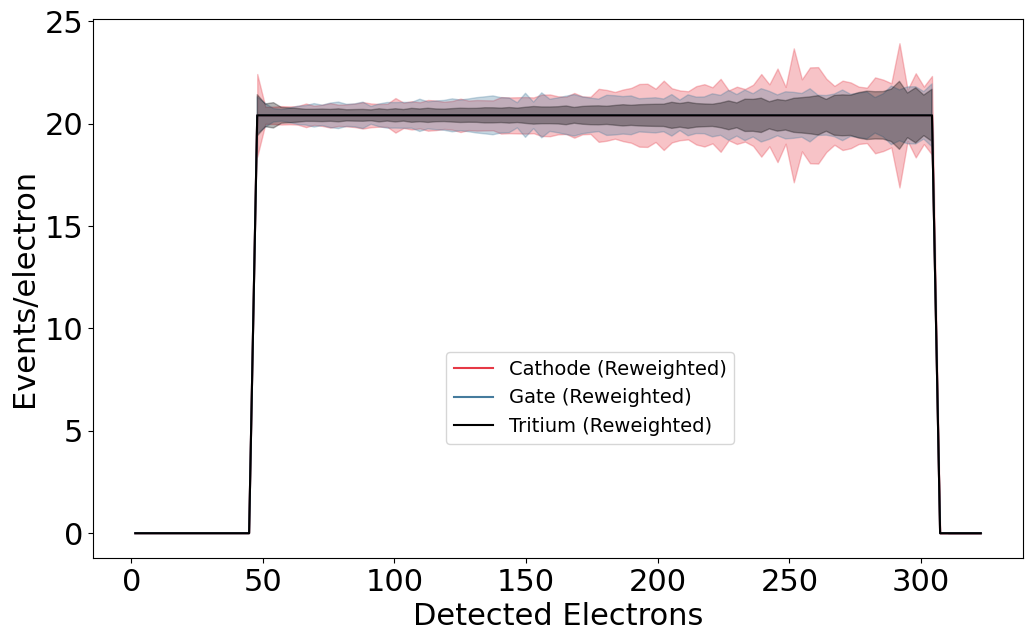

In [10]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 7), sharex=True, sharey=True)  #Initialise new fig object to plot weighted, flat spectrum
fig.subplots_adjust(hspace=0.0)

areas = arr['area']

max_tritium_area = max(areas[arr.label == 2])
max_gate_area = max(areas[arr.label == 1])
max_cathode_area = max(areas[arr.label == 0])
max_area = max(areas)
print(f'MAX areas: tritum,gate, cathode, overall dataset {max_tritium_area, max_gate_area, max_cathode_area, max_area}')

# Calculate the target flat spectrum as the average of the three histograms
gate_data = gate_hist.view(flow=False)
tritium_data = tritium_hist.view(flow=False) 
cathode_data = cathode_hist.view(flow=False) 

print(gate_counts.sum()) # total area under the histogram (integral of histogram)
print(tritium_counts.sum()) # total area under the histogram (integral of histogram)
print(cathode_counts.sum()) # total area under the histogram (integral of histogram)

average_counts = np.mean([gate_counts.sum(), tritium_counts.sum(),cathode_counts.sum()]) # average integral (area) of each histgoram to be used as reweighting benchmark

gate_weights = []
gate_reweighted  = []
for datapoint in range(len(gate_counts)):
    gate_reweighted.append(gate_counts[datapoint] * (1 / (gate_counts[datapoint] / gate_counts.sum())) if gate_counts[datapoint] != 0 else 0)
    gate_weights.append(1 / (gate_counts[datapoint] / gate_counts.sum()))

tritium_weights = []
tritium_reweighted = []
for datapoint in range(len(tritium_counts)):
    tritium_reweighted.append(tritium_counts[datapoint] * (1 / (tritium_counts[datapoint] / tritium_counts.sum())) if tritium_counts[datapoint] != 0 else 0)
    tritium_weights.append(1 / (tritium_counts[datapoint] / tritium_counts.sum()))

cathode_weights = []
cathode_reweighted = []
for datapoint in range(len(cathode_counts)):
    cathode_reweighted.append(cathode_counts[datapoint] * (1 / (cathode_counts[datapoint] / cathode_counts.sum())) if cathode_counts[datapoint] > cathode_counts[-1] else 0)
    cathode_weights.append(1 / (cathode_counts[datapoint] / cathode_counts.sum()) if datapoint < (len(cathode_counts)-1) else 0)

gate_reweighted = np.array(gate_reweighted)
tritium_reweighted = np.array(tritium_reweighted)

#tritium_reweighted[-1] = 37.92238004
cathode_reweighted = np.array(cathode_reweighted)

print(gate_reweighted)

#errorbars
gate_errors = np.sqrt(gate_counts) * gate_weights /70 # * (average_counts / gate_counts.sum())
tritium_errors = np.sqrt(tritium_counts) * tritium_weights /70 # * (average_counts / tritium_counts.sum())
cathode_errors = np.sqrt(cathode_counts) * cathode_weights/70 # * (average_counts / cathode_counts.sum())

# PADDING: Append zeros to make the histogram look like a "tophat"
tophat_padding = 5  # Number of zeros to add
gate_reweighted = np.append(gate_reweighted, [0] * tophat_padding)
tritium_reweighted = np.append(tritium_reweighted, [0] * tophat_padding)
cathode_reweighted = np.append(cathode_reweighted, [0] * tophat_padding)

gate_errors = np.append(gate_errors, [0] * tophat_padding)
tritium_errors = np.append(tritium_errors, [0] * tophat_padding)
cathode_errors = np.append(cathode_errors, [0] * tophat_padding)

# Extend bin_centers by adding extra bins to match the "tophat" shape
bin_step = bin_centers[1] - bin_centers[0]  # Calculate the step size between bins
extended_bin_centers = np.append(bin_centers, bin_centers[-1] + bin_step * np.arange(1, tophat_padding + 1))


# Apply reweighting by multiplying the original data by the weights

# Cathode
ax.plot(extended_bin_centers, cathode_reweighted * (average_counts / cathode_counts.sum()), color='#E63946', label='Cathode (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (cathode_reweighted - cathode_errors) * (average_counts / cathode_counts.sum()), 
    (cathode_reweighted + cathode_errors) * (average_counts / cathode_counts.sum()), 
    color='#E63946', alpha=0.3
)

# Gate
ax.plot(extended_bin_centers, gate_reweighted * (average_counts / gate_counts.sum()), color='#457B9D', label='Gate (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (gate_reweighted - gate_errors) * (average_counts / gate_counts.sum()), 
    (gate_reweighted + gate_errors) * (average_counts / gate_counts.sum()), 
    color='#457B9D', alpha=0.3
)

# Tritium
ax.plot(extended_bin_centers, tritium_reweighted * (average_counts / tritium_counts.sum()), color='black', label='Tritium (Reweighted)')
ax.fill_between(
    extended_bin_centers, 
    (tritium_reweighted - tritium_errors) * (average_counts / tritium_counts.sum()), 
    (tritium_reweighted + tritium_errors) * (average_counts / tritium_counts.sum()), 
    color='black', alpha=0.3
)

ax.set(xlabel='Detected Electrons',ylabel='Events/electron')
#ax.set_yscale('log')
ax.legend(bbox_to_anchor=(0.7,0.4),loc='upper right',frameon=True,fontsize=14) 
plt.savefig('/Users/laith_mohajer/Documents/GitHub/MSCIProject/Figures/HE_weighted_pulse_spectrum.png', dpi=1800)
plt.show()

# Creating the Weight Array to Feed into CNN

In [11]:
gate_weights = np.array(gate_weights)
gate_weights = np.where(np.isinf(gate_weights), 0, gate_weights) # check if values are defined (finite), 0 if not.

tritium_weights = np.array(tritium_weights)
tritium_weights = np.where(np.isinf(tritium_weights), 0, tritium_weights)

cathode_weights = np.array(cathode_weights)
cathode_weights = np.where(np.isinf(cathode_weights), 0, cathode_weights)

#gate_weights = gate_weights.ravel() # gate_weights was found to be a 2D array with only 1 row which prohibited proper indexing. ravel() flattens to 1D ndarray.
print(f'these are da {gate_weights.size}')

print(gate_data.sum())
print(tritium_data.sum())
print(cathode_data.sum())

def subdataset_total_weights(dataset_weights, n_data_per_bin):
    n_data_per_bin = np.array(n_data_per_bin, dtype=int) #creates a copy of array that is an ndarray with every element being an integer
    weight_list = []
    for i in range(bins):
        weight_list.extend([dataset_weights[i]] * n_data_per_bin[i])
    return np.array(weight_list)

g_weights = subdataset_total_weights(gate_weights, gate_data)
t_weights = subdataset_total_weights(tritium_weights, tritium_data)
c_weights = subdataset_total_weights(cathode_weights, cathode_data)

print(g_weights.size + t_weights.size + c_weights.size)
print(type(g_weights))
print(len(arr))

these are da 100
1711.0
4882.0
1189.0
7782
<class 'numpy.ndarray'>
7782


# Creating and Populating the New Weight Column in the Main Dataframe

In [12]:
weight_column_4_mainarray = np.zeros(len(arr))
# print(len(arr['weights'])) #check to ensure its same length as number of training examples

# Now we need to create an iterative loop that finds a cathode, gate or tritium training example and populates its assoicated weight with the correct weight parameter from its respective weight array

gate_event_counter = 0
cathode_event_counter = 0
tritium_event_counter = 0

print(len(t_weights))

for i in range(len(arr)):
    if arr['label'][i] == 0: # Cathode
        # print(g_weights[i])
        weight_column_4_mainarray[i] = c_weights[gate_event_counter]
        gate_event_counter += 1
    elif arr['label'][i] == 1: # Gate
        weight_column_4_mainarray[i] = g_weights[cathode_event_counter]
        cathode_event_counter += 1
    else: # Tritium (as we have already verified there are no None or NaN entries)
        weight_column_4_mainarray[i] = t_weights[tritium_event_counter]
        tritium_event_counter += 1

arr['weights'] = weight_column_4_mainarray # a new weight column has been initialised!

4882


# Optional Code: Normalising the Weights Array

In [13]:
num_events = len(arr['weights'])
total_weight = ak.sum(arr['weights'])
mean_weight = total_weight / num_events
weights_mean_one = arr['weights'] / mean_weight # rescale all weights to have a mean of 1.
arr = ak.with_field(arr, weights_mean_one, 'weights_normalised')
print(arr['weights_normalised'])

[4.23, 0.18, 1.1, 1.1, 1.1, 1.1, 1.1, ..., 6.14, 6.14, 6.14, 6.14, 6.14, 6.14]


# Convolutional Neural Network

In [14]:
seed_value = 42 # set a global random seed for model reproducibility
random.seed(seed_value)
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

In [15]:
from tensorflow.keras.callbacks import EarlyStopping

weights_np = ak.to_numpy(arr['weights'])
normalised_weights_np = ak.to_numpy(arr['weights_normalised'])
print(len(weights_np))
# An issue arises here initially as arr['weights'] is an awkward array. Keras only recognises and deals with a NumPy array therefore conversion is neccessary
# Another issue also arises in that the test and train data do not have asscoated weights as the weights column was initialised after the split was made
# 'arr' is the original dataset
normalised_area = ak.to_numpy(arr['area'] / electron_size)  # converting 'area' to detected electrons by dividing by 58.5

labels = arr['label']

radii = ak.to_numpy(arr['r'])

# TO ALTER BETWEEN WEIGHTS AND NORMLAISED WEIGHTS> CHANGE WEIGHTS_NP VARIABLE ACCORDINGLY> DEFAULT: NORMALISED WEIGHTS
X_train, X_test, y_train, y_test, area_train, area_test, weights_train, weights_test, \
normalised_times_train, normalised_times_test, times_us_train, times_us_test, \
normalised_samples_train, normalised_samples_test, r_train, r_test = train_test_split(
    X, labels, normalised_area, normalised_weights_np, normalised_times, time_us, normalised_samples, radii, 
    test_size=0.25, random_state=42
)

print("Length of X_train:", len(X_train))
print("Length of y_train:", len(y_train))
print("Length of weights_train:", len(weights_train))
print("Shape of weights_train:", weights_train.shape)
print("Shape of X_train:", X_train.shape)

y_train = np.array(y_train) # this is neccessary as train_test_split often returns lists instead of ndarrays but Keras.model.fit requires the functionality of ndarrays
y_test = np.array(y_test)
print("Shape of y_train:", y_train.shape)

y_test_np = ak.to_numpy(y_test)
area_test_np = ak.to_numpy(area_test)

X_train_padded = X_train.reshape(X_train.shape[0], X_train.shape[1], 1) # adding a channels dimension (greyscale of 1) to enable seamless input into CNN
X_test_padded = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_test_padded.shape)

7782
Length of X_train: 5836
Length of y_train: 5836
Length of weights_train: 5836
Shape of weights_train: (5836,)
Shape of X_train: (5836, 2828)
Shape of y_train: (5836,)
(1946, 2828, 1)


Smaller kernels in early layers capture local, fine-grained features (like edges or small peaks in your waveforms), while larger kernels in deeper layers can aggregate these to detect more complex patterns.
Smaller kernels in early layers (where the input has higher resolution/more time steps) also help to reduce computational load. Lastly, Even with small kernels, deeper layers naturally have a smaller effective receptive field due to the cumulative effect of convolutions through the network hence making it natural for deeper conv layers to have smaller kernels.

In [16]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor the validation loss
    min_delta=0.01,      # Minimum change in loss to qualify as an improvement
    patience=3,          # Stop training after 3 epochs of no significant improvement
    verbose=1,           # Print a message when stopping
    restore_best_weights=True  # Restore the weights from the best epoch
)

convoNN = keras.Sequential([
    # First 1D convolution layer
    keras.layers.Conv1D(filters=64, kernel_size=100, activation='relu', padding='same', input_shape=(X_train_padded.shape[1], 1)),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Second 1D convolution layer
    keras.layers.Conv1D(filters=154, kernel_size=60, padding='same', activation='relu'),
    keras.layers.MaxPooling1D(pool_size=2),
    
    # Flatten layer to connect to dense layers. 2D pooled feauture map flattened to 1D vector to input into dense outer layers.
    keras.layers.Flatten(),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(3, activation='softmax')  # Adjust output size for the number of classes
])

# Compile the model
optimizer = legacy.Adam(learning_rate=5.762e-4)
convoNN.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

#CNN with 7 layers
#the first two Conv2D extract spatial features from the image- i.e. there will be 64 filters that will scan the image for patterns, each filter extracts different features from the image (e.g.textures, edges)
#max Pooling layer performs down-sampling to resduce spatial dimensions
#(2) specifies a pooling window which means the layer will take the max value from every 2-linear-unit-wide region
#flatten layer converts information from 2D map to a 1D vector
#64 layer is a dense layer with 64 neurons

# K-Fold Cross Validation on Train Data


Training fold 1/5
Epoch 1/10
15/15 [==============================] - 225s 15s/step - loss: 0.5095 - accuracy: 0.7808 - val_loss: 0.3551 - val_accuracy: 0.8408
Epoch 2/10
15/15 [==============================] - 218s 15s/step - loss: 0.3836 - accuracy: 0.8477 - val_loss: 0.3243 - val_accuracy: 0.8553
Epoch 3/10
15/15 [==============================] - 187s 12s/step - loss: 0.3423 - accuracy: 0.8599 - val_loss: 0.2963 - val_accuracy: 0.8750
Epoch 4/10
15/15 [==============================] - 180s 12s/step - loss: 0.3084 - accuracy: 0.8805 - val_loss: 0.2805 - val_accuracy: 0.8784
Epoch 5/10
15/15 [==============================] - 181s 12s/step - loss: 0.2988 - accuracy: 0.8800 - val_loss: 0.2892 - val_accuracy: 0.8844
Epoch 6/10
15/15 [==============================] - 182s 12s/step - loss: 0.2954 - accuracy: 0.8783 - val_loss: 0.2907 - val_accuracy: 0.8647
Epoch 7/10
15/15 [==============================] - 180s 12s/step - loss: 0.2980 - accuracy: 0.8768 - val_loss: 0.2799 - val_accu

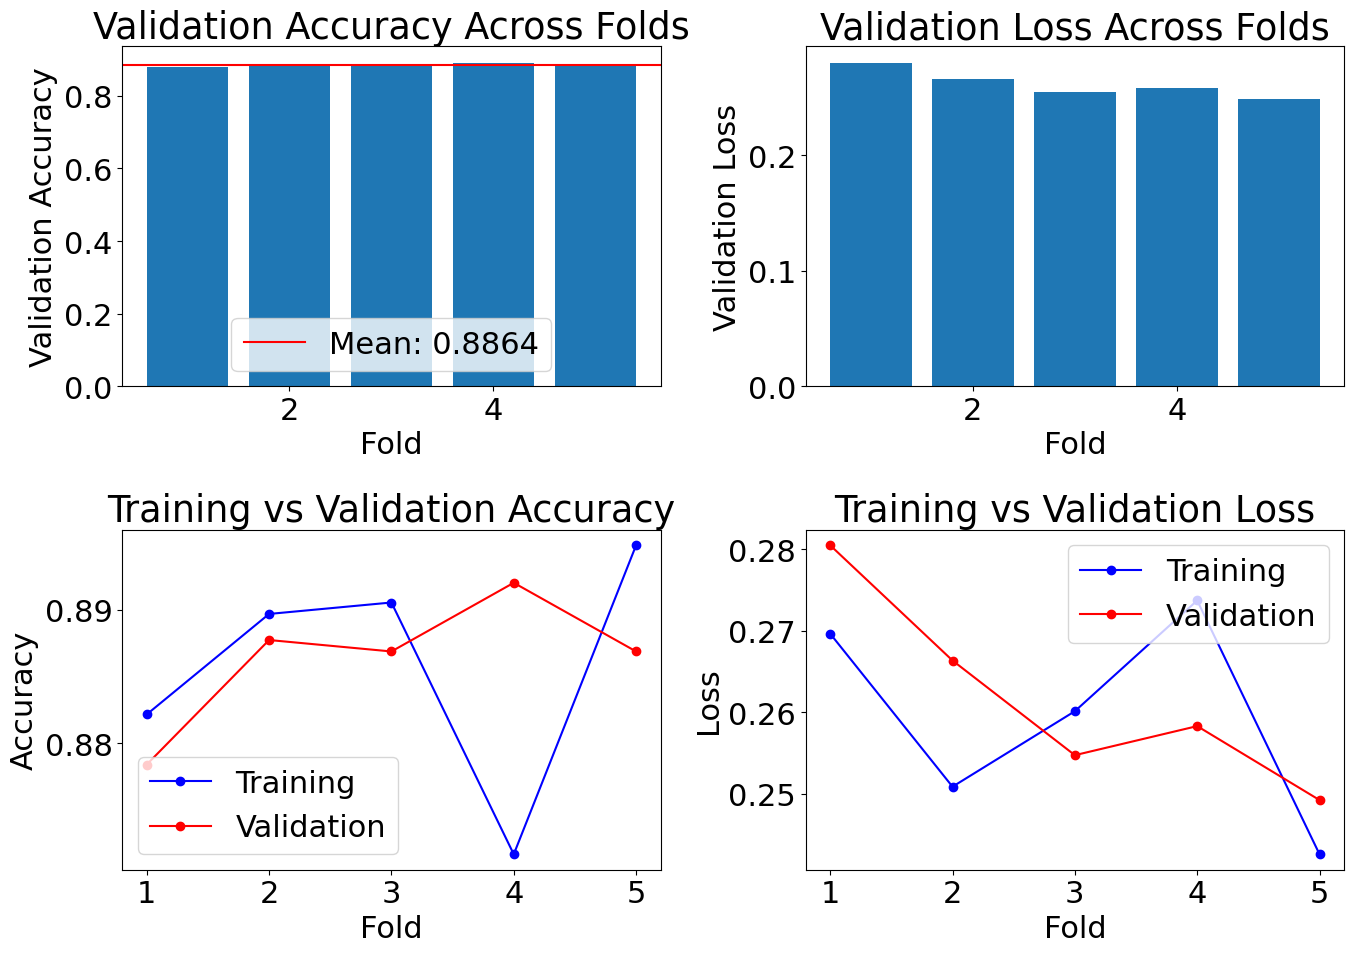

In [17]:
# K-fold Cross Validation implementation
def run_kfold_cv(X, y, sample_weights=None, n_splits=5, epochs=10, batch_size=323):
    # Initialize KFold
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    
    # Storage for metrics
    fold_accuracies = []
    fold_losses = []
    fold_val_accuracies = []
    fold_val_losses = []
    all_histories = []
    all_predictions = []
    all_true_labels = []
    fold_training_times = []
    
    # Define early stopping callback
    early_stopping = EarlyStopping(
        monitor='val_loss',
        min_delta=0.01,
        patience=3,
        verbose=1,
        restore_best_weights=True
    )
    
    # Perform K-fold cross-validation
    for fold, (train_idx, val_idx) in enumerate(kfold.split(X)):
        print(f"\nTraining fold {fold+1}/{n_splits}")
        
        # Split data for this fold
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]
        
        # Handle sample weights if provided
        if sample_weights is not None:
            weights_train_fold = sample_weights[train_idx]
        else:
            weights_train_fold = None
        
        # Create fresh model for each fold
        input_shape = (X_train_fold.shape[1], 1)
        model = convoNN
        
        # Train the model with timing
        start_time = time.time()
        
        # Fit model
        if weights_train_fold is not None:
            history = model.fit(
                X_train_fold, y_train_fold,
                sample_weight=weights_train_fold,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val_fold, y_val_fold),
                callbacks=[early_stopping],
                verbose=1
            )
        else:
            history = model.fit(
                X_train_fold, y_train_fold,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(X_val_fold, y_val_fold),
                callbacks=[early_stopping],
                verbose=1
            )
        
        # Calculate training time
        training_time = time.time() - start_time
        fold_training_times.append(training_time)
        
        # Evaluate the model on validation data
        val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        fold_val_losses.append(val_loss)
        fold_val_accuracies.append(val_accuracy)
        
        # Get final training metrics
        train_loss, train_accuracy = model.evaluate(X_train_fold, y_train_fold, verbose=0)
        fold_losses.append(train_loss)
        fold_accuracies.append(train_accuracy)
        
        # Save history
        all_histories.append(history.history)
        
        # Generate predictions for later analysis
        y_pred = np.argmax(model.predict(X_val_fold, verbose=0), axis=1)
        all_predictions.append(y_pred)
        all_true_labels.append(y_val_fold)
        
        # Print fold results
        print(f"Fold {fold+1} results:")
        print(f"Training accuracy: {train_accuracy:.4f}, loss: {train_loss:.4f}")
        print(f"Validation accuracy: {val_accuracy:.4f}, loss: {val_loss:.4f}")
        print(f"Training time: {training_time:.2f} seconds")
    
    # Calculate and print average performance
    mean_val_accuracy = np.mean(fold_val_accuracies)
    std_val_accuracy = np.std(fold_val_accuracies)
    mean_val_loss = np.mean(fold_val_losses)
    mean_train_accuracy = np.mean(fold_accuracies)
    mean_train_loss = np.mean(fold_losses)
    mean_training_time = np.mean(fold_training_times)
    
    print("\n===== K-Fold Cross-Validation Results =====")
    print(f"Number of folds: {n_splits}")
    print(f"Average validation accuracy: {mean_val_accuracy:.4f} ± {std_val_accuracy:.4f}")
    print(f"Average validation loss: {mean_val_loss:.4f}")
    print(f"Average training accuracy: {mean_train_accuracy:.4f}")
    print(f"Average training loss: {mean_train_loss:.4f}")
    print(f"Average training time per fold: {mean_training_time:.2f} seconds")
    
    return {
        'fold_accuracies': fold_accuracies,
        'fold_losses': fold_losses,
        'fold_val_accuracies': fold_val_accuracies,
        'fold_val_losses': fold_val_losses,
        'mean_val_accuracy': mean_val_accuracy,
        'std_val_accuracy': std_val_accuracy,
        'all_histories': all_histories,
        'all_predictions': all_predictions,
        'all_true_labels': all_true_labels,
        'fold_training_times': fold_training_times
    }

# Function to visualise cross-validation results
def plot_cv_results(cv_results):
    # Plot validation accuracy across folds
    plt.figure(figsize=(14, 10))
    
    # Plot 1: Validation accuracy across folds
    plt.subplot(2, 2, 1)
    plt.bar(range(1, len(cv_results['fold_val_accuracies'])+1), cv_results['fold_val_accuracies'])
    plt.axhline(y=cv_results['mean_val_accuracy'], color='r', linestyle='-', label=f'Mean: {cv_results["mean_val_accuracy"]:.4f}')
    plt.xlabel('Fold')
    plt.ylabel('Validation Accuracy')
    # plt.title('Validation Accuracy Across Folds')
    plt.legend()
    
    # Plot 2: Validation loss across folds
    plt.subplot(2, 2, 2)
    plt.bar(range(1, len(cv_results['fold_val_losses'])+1), cv_results['fold_val_losses'])
    plt.xlabel('Fold')
    plt.ylabel('Validation Loss')
    # plt.title('Validation Loss Across Folds')
    
    # Plot 3: Training vs Validation Accuracy
    plt.subplot(2, 2, 3)
    x = range(1, len(cv_results['fold_accuracies'])+1)
    plt.plot(x, cv_results['fold_accuracies'], 'bo-', label='Training')
    plt.plot(x, cv_results['fold_val_accuracies'], 'ro-', label='Validation')
    plt.xlabel('Fold')
    plt.ylabel('Accuracy')
    # plt.title('Training vs Validation Accuracy')
    plt.legend()
    
    # Plot 4: Training vs Validation Loss
    plt.subplot(2, 2, 4)
    plt.plot(x, cv_results['fold_losses'], 'bo-', label='Training')
    plt.plot(x, cv_results['fold_val_losses'], 'ro-', label='Validation')
    plt.xlabel('Fold')
    plt.ylabel('Loss')
    # plt.title('Training vs Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

cv_results = run_kfold_cv(
    X=X_train_padded,
    y=y_train,
    sample_weights=weights_train,
    n_splits=5,
    epochs=10,
    batch_size=323
)

plot_cv_results(cv_results)